# Two Object CNN Model 

## Libraries

##### Poniższa praca zawiera kilka podejść tworzenia i transformacji sieci U-NET. Na samym końcu znajduje się finalna wersja, z największą stabilnością i poprawnością działania

In [41]:
import tensorflow as tf
# from tensorflow.keras import layers
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os
from argparse import Namespace as SimpleNamespace


## Functions

In [42]:

# Define a function to calculate the output size after a convolution or pooling layer
def conv2d_output_size(input_size, kernel_size, padding=0, stride=1):
    output_size = (input_size - kernel_size + 2*padding) // stride + 1
    return output_size

# Define a function to calculate the size after a sequence of convolution and pooling
def calculate_conv_output_size(input_size, *layers):
    size = input_size
    for layer in layers:
        if isinstance(layer, nn.Conv2d):
            size = conv2d_output_size(size, layer.kernel_size[0], padding=layer.padding[0], stride=layer.stride[0])
        elif isinstance(layer, nn.MaxPool2d):
            size = conv2d_output_size(size, layer.kernel_size, padding=layer.padding, stride=layer.stride)
    return size

def create_mask(image, x, y):
    mask = torch.zeros_like(image)
    mask[:, y:y+28, x:x+28] = 1
    return mask

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f'Validation Loss: {val_loss / len(val_loader)}')

In [3]:
def number_to_binary_vector(number):
    binary_vector = [0] * 10
    binary_vector[number] = 1
    return binary_vector

def spatial_label_to_vector(label):
    binary_vector = [0] * 4
    if label == "left":
        binary_vector[0] = 1
    elif label == "above":
        binary_vector[1] = 1
    elif label == "below left":
        binary_vector[2] = 1
    if label == "below right":
        binary_vector[3] = 1
    return binary_vector

def outcomeVector(label_1, label_2, spatial_label):
    if spatial_label == "above right":
        label_1, label_2 = label_2, label_1
        spatial_label = "below left"
    elif spatial_label == "above left":
        label_1, label_2 = label_2, label_1
        spatial_label = "below right"
    vector1 = number_to_binary_vector(label_1)
    vector2 = number_to_binary_vector(label_2)
    vector12 = np.concatenate((vector1, vector2))
    vector3 = spatial_label_to_vector(spatial_label)
    vector = np.concatenate((vector12, vector3))
    return vector

def spatial_relation_labels(x1,y1,x2,y2):
    
    if y1 == y2:
        label = "left"
    elif x1 == x2:
        label = "above"
    elif x1< x2 and y1 < y2:
        label = "above left"
    elif x1 > x2 and y1 < y2:
        label = "above right"
    else:
        label = "below left"
    return label

In [4]:
def create_samples_with_non_overlapping_images_and_vectors(train_loader, num_samples=100):
    samples = []
    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)

        idx1, idx2 = np.random.choice(len(train_loader.dataset), 2, replace=False)
        img1, label_1 = train_loader.dataset[idx1]
        img2, label_2 = train_loader.dataset[idx2]
        
        while True:
            if label_1 == label_2:
                idx2 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
                img2, label_2 = train_loader.dataset[idx2]
                continue
            else:
                break

        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        
        a = np.random.randint(-27, 28)

        if a >= 0:
            x1 = a
            y1 = 0
        else:
            x1 = 0
            y1 = abs(a)
        
        if x1 > 0 and y1 == 0:
            y2 = 27
            x2 = np.random.randint(0, 28)
        elif x1 == 0 and y1 == 0:
            b = np.random.randint(0, 56)
            if b < 28:
                x2 = b
                y2 = 27
            else:
                x2 = 27
                y2 = 55 - b
        else:
            x2 = 27
            y2 = np.random.randint(0, 28)
            
        background[:, y1:y1+28, x1:x1+28] = img1
        background[:, y2:y2+28, x2:x2+28] = img2
        
        # Create masks
        mask1 = create_mask(background, x1, y1)
        mask2 = create_mask(background, x2, y2)
        
        # Combine masks into a single mask with different labels
        combined_mask = torch.zeros_like(background)
        combined_mask[mask1 == 1] = 1
        combined_mask[mask2 == 1] = 2
        
        spatial_label = spatial_relation_labels(x1,y1,x2,y2)
        vector = outcomeVector(label_1, label_2, spatial_label)

        samples.append((background, combined_mask, vector))

    return samples

In [43]:
def transform_loader(data_loader, num_samples=None):
    if num_samples is None:
        num_samples = len(data_loader.dataset)
    
    transformed_data = create_samples_with_non_overlapping_images_and_vectors(data_loader, num_samples)
    return transformed_data

## Loading Data

In [44]:
from torchvision import datasets, transforms
import torch
from sklearn.model_selection import train_test_split
import os
from argparse import Namespace as SimpleNamespace

# Arguments
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1, lr=0.01, momentum=0.5, seed=1, log_interval=100)

# Use CUDA if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the transformation for the dataset
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full FashionMNIST training and test datasets
full_train_dataset = datasets.FashionMNIST(
    os.path.join('.','..','data'), 
    train=True, 
    download=True, 
    transform=transformation
)
full_test_dataset = datasets.FashionMNIST(
    os.path.join('.','..','data'), 
    train=False, 
    download=True, 
    transform=transformation
)

# Combine train and test datasets
full_dataset = torch.utils.data.ConcatDataset([full_train_dataset, full_test_dataset])

# Arguments
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1, lr=0.01, momentum=0.5, seed=1, log_interval=100)

# Use CUDA if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Set the manual seed for reproducibility
torch.manual_seed(args.seed)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.64 * total_size)
val_size = int(0.16 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])

# Define data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)

# Check proportions
print(f'Train data is {100 * len(train_dataset) / total_size}% of the dataset')
print(f'Val data is {100 * len(val_dataset) / total_size}% of the dataset')
print(f'Test data is {100 * len(test_dataset) / total_size}% of the dataset')


100%|██████████| 26421880/26421880 [00:10<00:00, 2569711.58it/s]


Extracting .\..\data\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\..\data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 747409.21it/s]


Extracting .\..\data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\..\data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1787309.00it/s]


Extracting .\..\data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\..\data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]


Extracting .\..\data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\..\data\FashionMNIST\raw

Train data is 64.0% of the dataset
Val data is 16.0% of the dataset
Test data is 20.0% of the dataset


# Preprocessing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


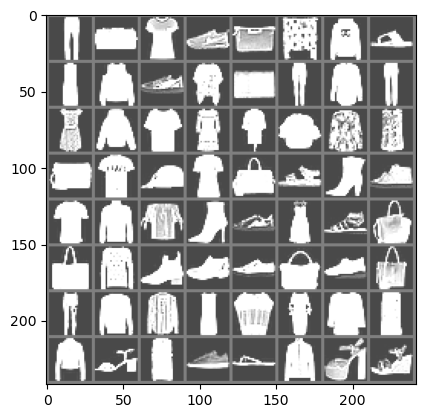

Labels:  [1, 8, 0, 7, 8, 6, 2, 5, 6, 2, 7, 6, 8, 1, 6, 1, 3, 4, 0, 3, 4, 8, 6, 0, 8, 0, 8, 0, 8, 5, 9, 7, 0, 4, 6, 9, 7, 3, 5, 8, 8, 2, 9, 9, 7, 8, 7, 8, 1, 2, 6, 3, 6, 3, 0, 0, 4, 5, 0, 7, 5, 4, 5, 5]


In [45]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next() to fetch the next batch

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels: ', labels.tolist())


In [46]:
train_data = transform_loader(train_loader)
val_data = transform_loader(val_loader)
test_data = transform_loader(test_loader)

## Examples

Example nr 1: 
Input: 


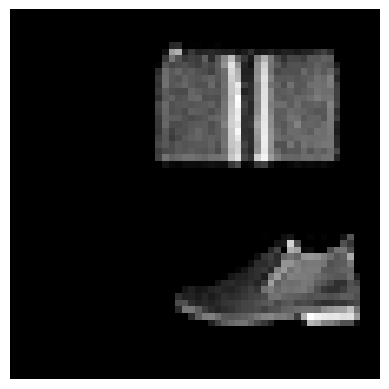

Mask: 


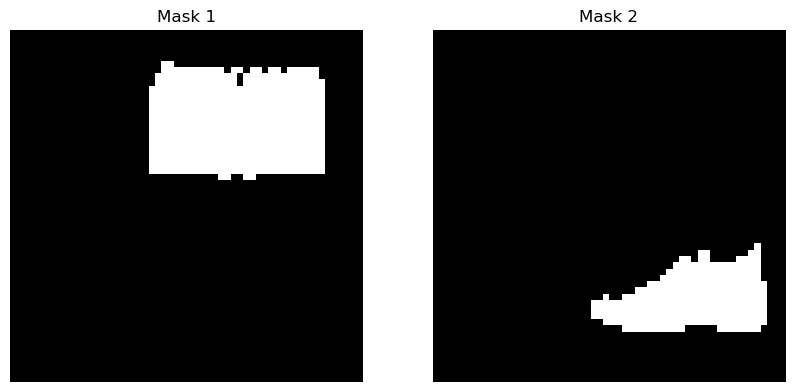

Output vector:  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Object 1 (Label, Position):  (8, (22, 0))
Object 2 (Label, Position):  (9, (25, 27)) 

Example nr 2: 
Input: 


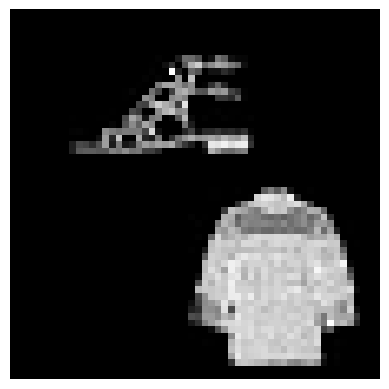

Mask: 


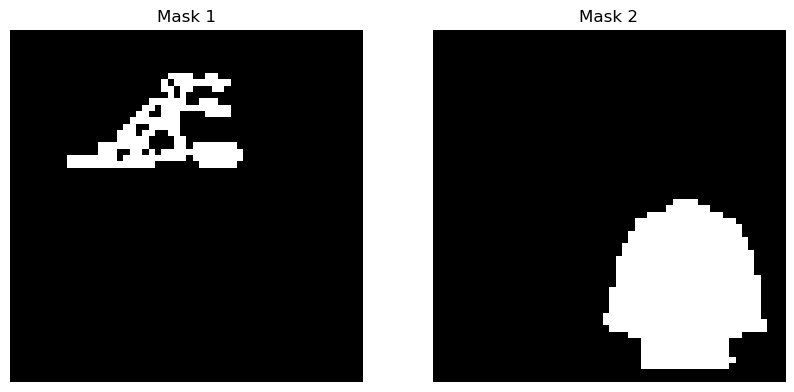

Output vector:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Object 1 (Label, Position):  (5, (9, 0))
Object 2 (Label, Position):  (6, (26, 27)) 

Example nr 3: 
Input: 


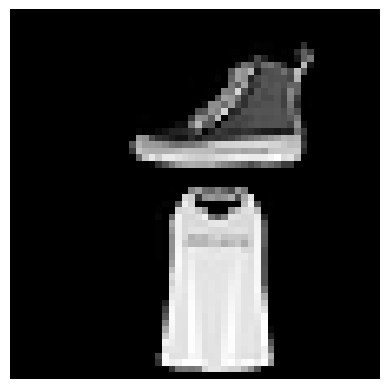

Mask: 


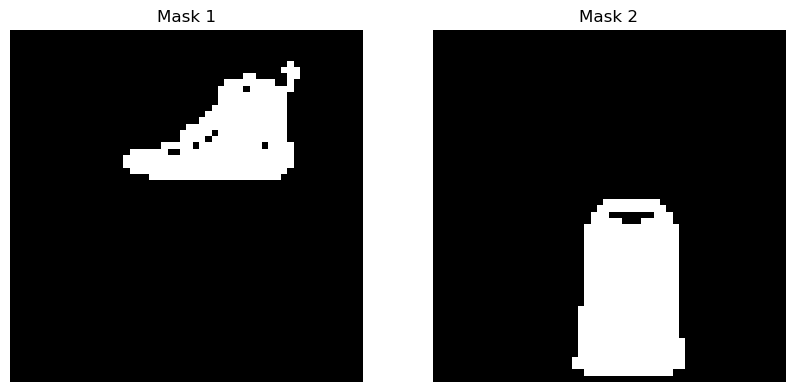

Output vector:  [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Object 1 (Label, Position):  (9, (18, 0))
Object 2 (Label, Position):  (0, (17, 27)) 

Example nr 4: 
Input: 


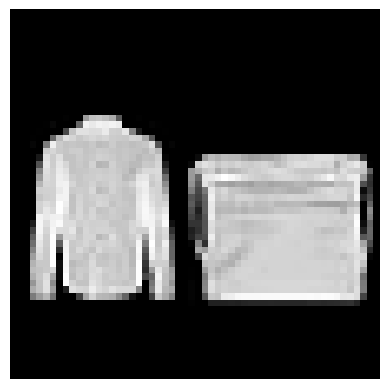

Mask: 


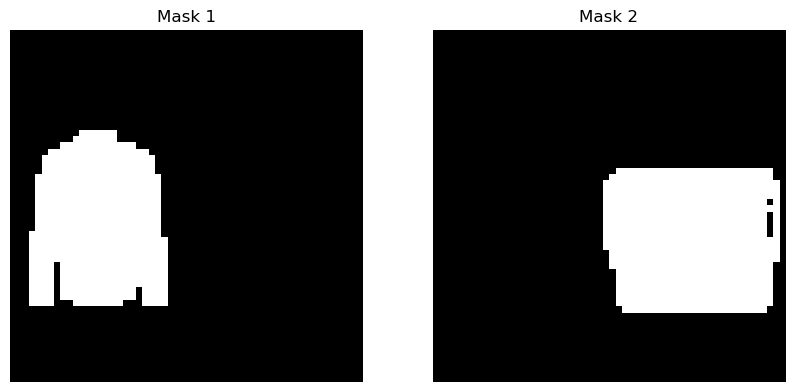

Output vector:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Object 1 (Label, Position):  (6, (0, 16))
Object 2 (Label, Position):  (8, (27, 19)) 

Example nr 5: 
Input: 


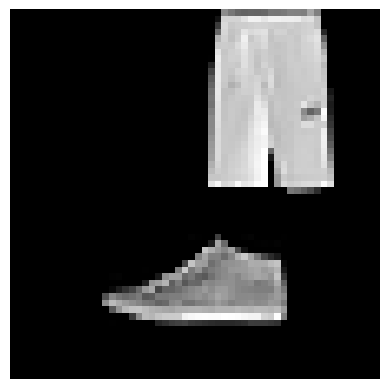

Mask: 


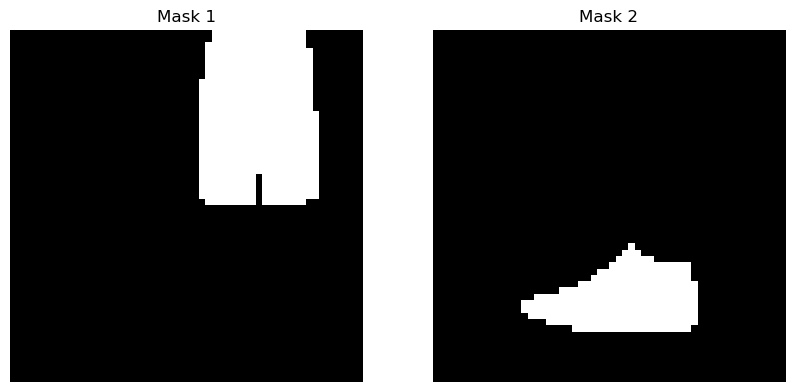

Output vector:  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Object 1 (Label, Position):  (1, (25, 0))
Object 2 (Label, Position):  (7, (14, 27)) 



In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

def number_to_binary_vector(number):
    binary_vector = [0] * 10
    binary_vector[number] = 1
    return binary_vector

def spatial_label_to_vector(label):
    binary_vector = [0] * 4
    if label == "left":
        binary_vector[0] = 1
    elif label == "above":
        binary_vector[1] = 1
    elif label == "below left":
        binary_vector[2] = 1
    elif label == "below right":
        binary_vector[3] = 1
    return binary_vector

def outcomeVector(label_1, label_2, spatial_label):
    vector1 = number_to_binary_vector(label_1)
    vector2 = number_to_binary_vector(label_2)
    vector12 = np.concatenate((vector1, vector2))
    vector3 = spatial_label_to_vector(spatial_label)
    vector = np.concatenate((vector12, vector3))
    return vector

def spatial_relation_labels(x1, y1, x2, y2):
    if y1 == y2:
        return "left"
    elif x1 == x2:
        return "above"
    elif x1 < x2 and y1 < y2:
        return "above left"
    elif x1 > x2 and y1 < y2:
        return "above right"
    elif x1 < x2 and y1 > y2:
        return "below left"
    else:
        return "below right"

def create_mask(image, threshold=0.1):
    mask = (image > threshold).float()
    return mask

def create_samples_with_non_overlapping_images_and_vectors(train_loader, num_samples=100):
    samples = []
    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)

        idx1, idx2 = np.random.choice(len(train_loader.dataset), 2, replace=False)
        img1, label_1 = train_loader.dataset[idx1]
        img2, label_2 = train_loader.dataset[idx2]
        
        while label_1 == label_2:
            idx2 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
            img2, label_2 = train_loader.dataset[idx2]

        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        
        a = np.random.randint(-27, 28)
        if a >= 0:
            x1, y1 = a, 0
        else:
            x1, y1 = 0, abs(a)
        
        if x1 > 0 and y1 == 0:
            y2, x2 = 27, np.random.randint(0, 28)
        elif x1 == 0 and y1 == 0:
            b = np.random.randint(0, 56)
            if b < 28:
                x2, y2 = b, 27
            else:
                x2, y2 = 27, 55 - b
        else:
            x2, y2 = 27, np.random.randint(0, 28)
            
        background[:, y1:y1+28, x1:x1+28] = img1
        background[:, y2:y2+28, x2:x2+28] = img2
        
        mask1 = create_mask(img1)
        mask2 = create_mask(img2)
        
        combined_mask = torch.zeros((2, 56, 56))  # two channels for two different masks
        combined_mask[0, y1:y1+28, x1:x1+28] = mask1
        combined_mask[1, y2:y2+28, x2:x2+28] = mask2
        
        spatial_label = spatial_relation_labels(x1, y1, x2, y2)
        vector = outcomeVector(label_1, label_2, spatial_label)

        samples.append((background, combined_mask, vector, (label_1, (x1, y1)), (label_2, (x2, y2))))

    return samples

def transform_loader(data_loader, num_samples=None):
    if num_samples is None:
        num_samples = len(data_loader.dataset)
    transformed_data = create_samples_with_non_overlapping_images_and_vectors(data_loader, num_samples)
    return transformed_data

# Define the transformation for the dataset
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full FashionMNIST training and test datasets
full_train_dataset = datasets.FashionMNIST('.', train=True, download=True, transform=transformation)
full_test_dataset = datasets.FashionMNIST('.', train=False, download=True, transform=transformation)

# Combine train and test datasets
full_dataset = torch.utils.data.ConcatDataset([full_train_dataset, full_test_dataset])

# Split the dataset
total_size = len(full_dataset)
train_size = int(0.64 * total_size)
val_size = int(0.16 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_test_dataset = random_split(full_dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Transform data loaders
train_data = transform_loader(train_loader)
val_data = transform_loader(val_loader)
test_data = transform_loader(test_loader)

# Show an example
samples = create_samples_with_non_overlapping_images_and_vectors(test_loader, 5)
for i in range(5):
    img, mask, vector, obj1_info, obj2_info = samples[i]
    print(f"Example nr {i+1}: ")
    print("Input: ")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    print("Mask: ")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(mask[0].squeeze(), cmap='gray')
    axes[0].set_title('Mask 1')
    axes[0].axis('off')
    axes[1].imshow(mask[1].squeeze(), cmap='gray')
    axes[1].set_title('Mask 2')
    axes[1].axis('off')
    plt.show()
    print("Output vector: ", vector)
    print("Object 1 (Label, Position): ", obj1_info)
    print("Object 2 (Label, Position): ", obj2_info, "\n")

In [77]:
samples

[(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0]),
  (8, (22, 0)),
  (9, (25, 27))),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = up_conv(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.dec1 = conv_block(128, 64)
        
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, self.crop(enc4, dec4)), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, self.crop(enc3, dec3)), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, self.crop(enc2, dec2)), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, self.crop(enc1, dec1)), dim=1)
        dec1 = self.dec1(dec1)
        
        output = self.conv_final(dec1)
        output = F.interpolate(output, size=(56, 56), mode='bilinear', align_corners=True) # Ensure output size matches target size
        return output
    
    def crop(self, enc, dec):
        _, _, H, W = dec.size()
        enc = F.interpolate(enc, size=(H, W), mode='bilinear', align_corners=True)
        return enc

def train_unet(model, train_loader, val_loader, num_epochs=1, learning_rate=0.001, device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, (imgs, masks) in enumerate(train_loader):
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Print progress
            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

def test_unet(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    test_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            print(f"Batch Loss: {loss.item():.4f}")
    
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    
    return test_loss

def visualize_predictions(model, data_loader, num_samples=5, device='cpu'):
    model = model.to(device)
    model.eval()
    
    samples = []
    with torch.no_grad():
        for imgs, masks in data_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            samples.extend(zip(imgs.cpu(), masks.cpu(), outputs.cpu()))
            if len(samples) >= num_samples:
                break
    
    for i, (img, true_mask, pred_mask) in enumerate(samples[:num_samples]):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(true_mask[0].squeeze(), cmap='gray', alpha=0.5)
        plt.imshow(true_mask[1].squeeze(), cmap='gray', alpha=0.5)
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(torch.sigmoid(pred_mask[0]).squeeze(), cmap='gray', alpha=0.5)
        plt.imshow(torch.sigmoid(pred_mask[1]).squeeze(), cmap='gray', alpha=0.5)
        plt.axis('off')
        
        plt.show()

In [96]:
from torch.utils.data import Subset

def split_dataset(dataset, train_percent=0.2, val_percent=0.05):
    total_size = len(dataset)
    train_size = int(train_percent * total_size)
    val_size = int(val_percent * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_test_dataset = random_split(dataset, [train_size, val_size + test_size])
    val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])
    
    return train_dataset, val_dataset, test_dataset

# Define the transformation for the dataset
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full FashionMNIST training and test datasets
full_train_dataset = datasets.FashionMNIST('.', train=True, download=True, transform=transformation)
full_test_dataset = datasets.FashionMNIST('.', train=False, download=True, transform=transformation)

# Combine train and test datasets
full_dataset = torch.utils.data.ConcatDataset([full_train_dataset, full_test_dataset])

# Split the dataset with the given percentages
train_percent = 0.03  # example value, 50% for training
val_percent = 0.01   # example value, 25% for validation

train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, train_percent=train_percent, val_percent=val_percent)


test_subset = Subset(test_dataset, list(range(100)))
# Define data loaders
batch_size = 8  # Zmniejsz rozmiar batcha
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

for imgs, masks in test_loader:
    print(imgs.shape, masks.shape)  # Sprawdź rozmiary danych
    break


# Transform data loaders
train_data = transform_loader(train_loader)
val_data = transform_loader(val_loader)
test_data = transform_loader(test_loader)

# Przygotowanie danych do treningu
train_dataset = [(sample[0], sample[1]) for sample in train_data]
val_dataset = [(sample[0], sample[1]) for sample in val_data]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Inicjalizacja modelu i trening
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model = UNet(in_channels=1, out_channels=2)
train_losses, val_losses = train_unet(unet_model, train_loader, val_loader, device=device)


# Testowanie modelu
test_dataset = [(sample[0], sample[1]) for sample in test_data]
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
test_loss = test_unet(unet_model, test_loader, device=device)

# Wizualizacja wyników

torch.Size([8, 1, 28, 28]) torch.Size([8])
Epoch [1/1], Step [1/132], Loss: 0.6755
Epoch [1/1], Step [11/132], Loss: 0.3256
Epoch [1/1], Step [21/132], Loss: 0.2112
Epoch [1/1], Step [31/132], Loss: 0.1991
Epoch [1/1], Step [41/132], Loss: 0.1820
Epoch [1/1], Step [51/132], Loss: 0.1777
Epoch [1/1], Step [61/132], Loss: 0.1773
Epoch [1/1], Step [71/132], Loss: 0.1695
Epoch [1/1], Step [81/132], Loss: 0.1891
Epoch [1/1], Step [91/132], Loss: 0.1694
Epoch [1/1], Step [101/132], Loss: 0.3543
Epoch [1/1], Step [111/132], Loss: 0.1587
Epoch [1/1], Step [121/132], Loss: 0.1755
Epoch [1/1], Step [131/132], Loss: 0.1821
Epoch 1/1, Train Loss: 0.2129, Validation Loss: 0.1789
Batch Loss: 0.1540
Batch Loss: 0.1701
Batch Loss: 0.1727
Batch Loss: 0.1739
Batch Loss: 0.1679
Batch Loss: 0.1727
Batch Loss: 0.1686
Test Loss: 0.1686


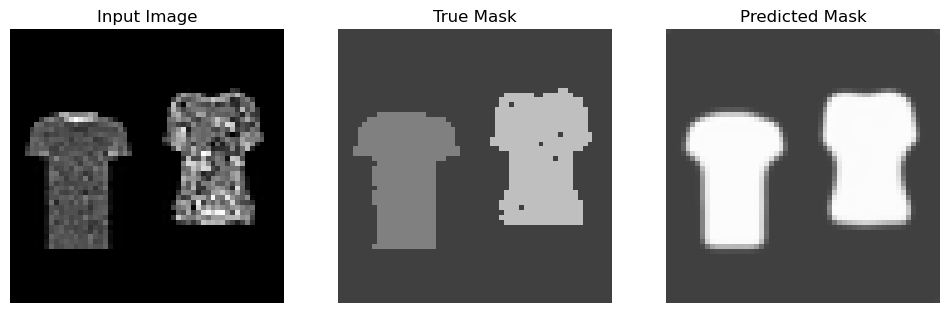

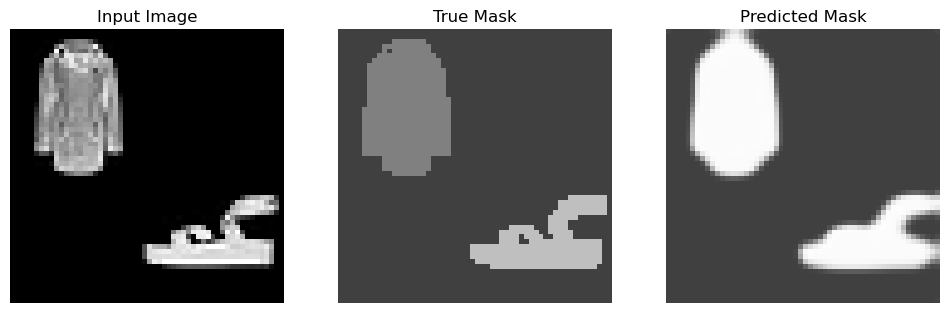

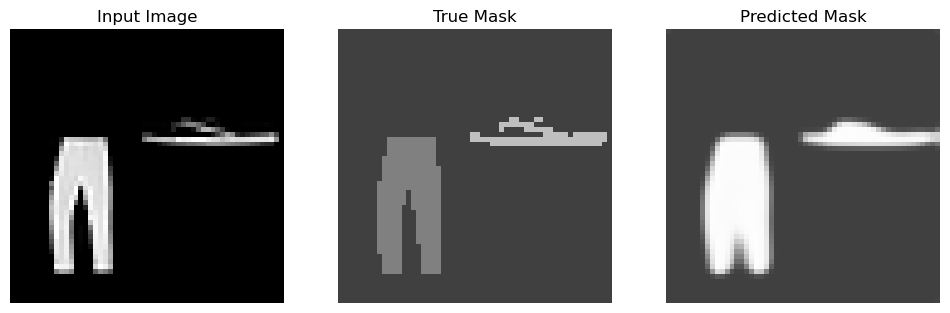

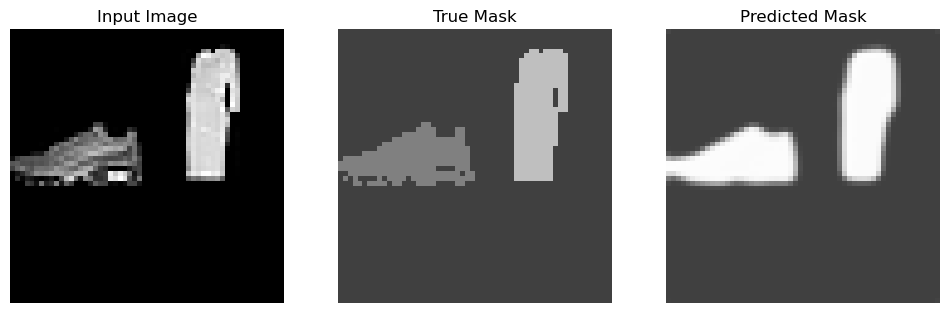

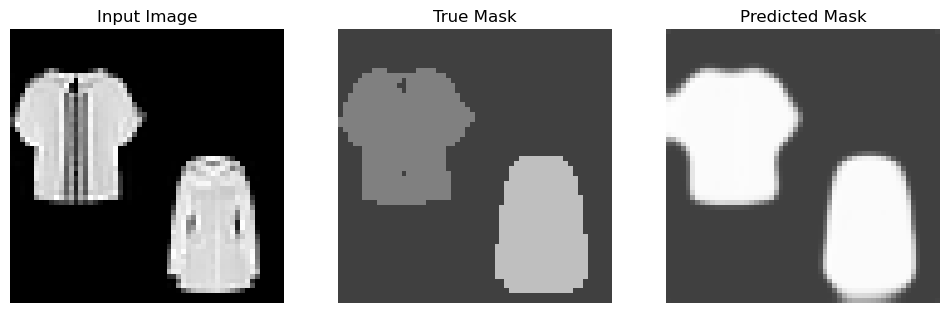

In [97]:
visualize_predictions(unet_model, test_loader, device=device)

In [40]:
n = 0
for i in range(56):
    for j in range(56):
        if samples[0][0][0][i][j] > 0:
            n += 1
print(n)

1051


# Poprawione podejście

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import numpy as np

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = datasets.FashionMNIST('.', train=True, download=True, transform=transformation)
full_test_dataset = datasets.FashionMNIST('.', train=False, download=True, transform=transformation)

full_dataset = torch.utils.data.ConcatDataset([full_train_dataset, full_test_dataset])

# zmniejszanie danych uczących w celach testowych (uczenie 0.03% danych zajmowało około 7-10 min)
train_percent = 0.03
val_percent = 0.01

def split_dataset(dataset, train_percent=0.2, val_percent=0.05):
    total_size = len(dataset)
    train_size = int(train_percent * total_size)
    val_size = int(val_percent * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_test_dataset = random_split(dataset, [train_size, val_size + test_size])
    val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])
    
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, train_percent=train_percent, val_percent=val_percent)

test_subset = Subset(test_dataset, list(range(100)))
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

def number_to_binary_vector(number):
    binary_vector = [0] * 10
    binary_vector[number] = 1
    return binary_vector

def spatial_label_to_vector(label):
    binary_vector = [0] * 4
    if label == "left":
        binary_vector[0] = 1
    elif label == "above":
        binary_vector[1] = 1
    elif label == "below left":
        binary_vector[2] = 1
    elif label == "below right":
        binary_vector[3] = 1
    return binary_vector

def outcomeVector(label_1, label_2, spatial_label):
    vector1 = number_to_binary_vector(label_1)
    vector2 = number_to_binary_vector(label_2)
    vector12 = np.concatenate((vector1, vector2))
    vector3 = spatial_label_to_vector(spatial_label)
    vector = np.concatenate((vector12, vector3))
    return vector

def spatial_relation_labels(x1, y1, x2, y2):
    if y1 == y2:
        return "left"
    elif x1 == x2:
        return "above"
    elif x1 < x2 and y1 < y2:
        return "above left"
    elif x1 > x2 and y1 < y2:
        return "above right"
    elif x1 < x2 and y1 > y2:
        return "below left"
    else:
        return "below right"

def create_mask(image, threshold=0.1):
    mask = (image > threshold).float()
    return mask

def create_samples_with_non_overlapping_images_and_vectors(train_loader, num_samples=100):
    samples = []
    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)

        idx1, idx2 = np.random.choice(len(train_loader.dataset), 2, replace=False)
        img1, label_1 = train_loader.dataset[idx1]
        img2, label_2 = train_loader.dataset[idx2]
        
        while label_1 == label_2:
            idx2 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
            img2, label_2 = train_loader.dataset[idx2]

        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        
        a = np.random.randint(-27, 28)
        if a >= 0:
            x1, y1 = a, 0
        else:
            x1, y1 = 0, abs(a)
        
        if x1 > 0 and y1 == 0:
            y2, x2 = 27, np.random.randint(0, 28)
        elif x1 == 0 and y1 == 0:
            b = np.random.randint(0, 56)
            if b < 28:
                x2, y2 = b, 27
            else:
                x2, y2 = 27, 55 - b
        else:
            x2, y2 = 27, np.random.randint(0, 28)
            
        background[:, y1:y1+28, x1:x1+28] = img1
        background[:, y2:y2+28, x2:x2+28] = img2
        
        mask1 = create_mask(img1)
        mask2 = create_mask(img2)
        
        combined_mask = torch.zeros((2, 56, 56)) # Poprawiona interpretacja dwóch masek
        combined_mask[0, y1:y1+28, x1:x1+28] = mask1
        combined_mask[1, y2:y2+28, x2:x2+28] = mask2
        
        spatial_label = spatial_relation_labels(x1, y1, x2, y2)
        vector = outcomeVector(label_1, label_2, spatial_label)

        samples.append((background, combined_mask, vector, (label_1, (x1, y1)), (label_2, (x2, y2))))

    return samples

def transform_loader(data_loader, num_samples=None):
    if num_samples is None:
        num_samples = len(data_loader.dataset)
    transformed_data = create_samples_with_non_overlapping_images_and_vectors(data_loader, num_samples)
    return transformed_data

train_data = transform_loader(train_loader)
val_data = transform_loader(val_loader)
test_data = transform_loader(test_loader)

train_dataset = [(sample[0], sample[1]) for sample in train_data]
val_dataset = [(sample[0], sample[1]) for sample in val_data]
test_dataset = [(sample[0], sample[1]) for sample in test_data]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [108]:
# U-NET
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = up_conv(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.dec1 = conv_block(128, 64)
        
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, self.crop(enc4, dec4)), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, self.crop(enc3, dec3)), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, self.crop(enc2, dec2)), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, self.crop(enc1, dec1)), dim=1)
        dec1 = self.dec1(dec1)
        
        output = self.conv_final(dec1)
        output = F.interpolate(output, size=(56, 56), mode='bilinear', align_corners=True)
        return output
    
    def crop(self, enc, dec):
        _, _, H, W = dec.size()
        enc = F.interpolate(enc, size=(H, W), mode='bilinear', align_corners=True)
        return enc

def train_unet(model, train_loader, val_loader, num_epochs=1, learning_rate=0.001, device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, (imgs, masks) in enumerate(train_loader):
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Print progress
            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

def test_unet(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    test_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            print(f"Batch Loss: {loss.item():.4f}")
    
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    
    return test_loss

def extract_and_classify_clothing(model, data_loader, num_samples=5, device='cpu'):
    model = model.to(device)
    model.eval()
    
    samples = []
    with torch.no_grad():
        for imgs, masks in data_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            samples.extend(zip(imgs.cpu(), masks.cpu(), outputs.cpu()))
            if len(samples) >= num_samples:
                break
    
    for i, (img, true_mask, pred_mask) in enumerate(samples[:num_samples]):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 5, 1)
        plt.title('Input Image')
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 2)
        plt.title('True Mask 1')
        plt.imshow(true_mask[0].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 3)
        plt.title('True Mask 2')
        plt.imshow(true_mask[1].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 4)
        plt.title('Predicted Mask 1')
        plt.imshow(torch.sigmoid(pred_mask[0]).squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 5)
        plt.title('Predicted Mask 2')
        plt.imshow(torch.sigmoid(pred_mask[1]).squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.show()
        
        pred_mask1 = torch.sigmoid(pred_mask[0]).squeeze().numpy()
        pred_mask2 = torch.sigmoid(pred_mask[1]).squeeze().numpy()
        
        obj1_img = img.squeeze().numpy() * pred_mask1
        obj2_img = img.squeeze().numpy() * pred_mask2
        
        obj1_label = torch.argmax(true_mask[0].sum((1, 2)))
        obj2_label = torch.argmax(true_mask[1].sum((1, 2)))
        
        print(f'Object 1 Label: {obj1_label}, Object 2 Label: {obj2_label}')
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title(f'Object 1 (Label {obj1_label})')
        plt.imshow(obj1_img, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title(f'Object 2 (Label {obj2_label})')
        plt.imshow(obj2_img, cmap='gray')
        plt.axis('off')
        
        plt.show()

# Inicjalizacja modelu i trening
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model = UNet(in_channels=1, out_channels=2)
train_losses, val_losses = train_unet(unet_model, train_loader, val_loader, num_epochs=1, device=device)

# Testowanie modelu
test_loss = test_unet(unet_model, test_loader, device=device)

Epoch [1/1], Step [1/132], Loss: 0.6915
Epoch [1/1], Step [11/132], Loss: 0.5559
Epoch [1/1], Step [21/132], Loss: 0.3375
Epoch [1/1], Step [31/132], Loss: 0.2337
Epoch [1/1], Step [41/132], Loss: 0.1947
Epoch [1/1], Step [51/132], Loss: 0.1824
Epoch [1/1], Step [61/132], Loss: 0.1785
Epoch [1/1], Step [71/132], Loss: 0.1860
Epoch [1/1], Step [81/132], Loss: 0.1692
Epoch [1/1], Step [91/132], Loss: 0.1702
Epoch [1/1], Step [101/132], Loss: 0.1806
Epoch [1/1], Step [111/132], Loss: 0.1701
Epoch [1/1], Step [121/132], Loss: 0.1756
Epoch [1/1], Step [131/132], Loss: 0.1372
Epoch 1/1, Train Loss: 0.2648, Validation Loss: 0.2016
Batch Loss: 0.1740
Batch Loss: 0.2456
Batch Loss: 0.2204
Batch Loss: 0.1968
Batch Loss: 0.2236
Batch Loss: 0.2420
Batch Loss: 0.1609
Test Loss: 0.2090


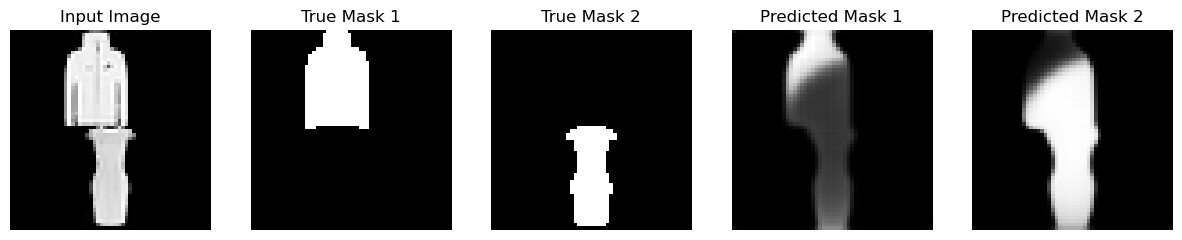

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [109]:
extract_and_classify_clothing(unet_model, test_loader, num_samples=5, device=device)

# Poprawa skryptu oraz łączenie w całość

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import numpy as np

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = datasets.FashionMNIST('.', train=True, download=True, transform=transformation)
full_test_dataset = datasets.FashionMNIST('.', train=False, download=True, transform=transformation)

full_dataset = torch.utils.data.ConcatDataset([full_train_dataset, full_test_dataset])

train_percent = 0.03
val_percent = 0.01

def split_dataset(dataset, train_percent=0.2, val_percent=0.05):
    total_size = len(dataset)
    train_size = int(train_percent * total_size)
    val_size = int(val_percent * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_test_dataset = random_split(dataset, [train_size, val_size + test_size])
    val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])
    
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, train_percent=train_percent, val_percent=val_percent)

test_subset = Subset(test_dataset, list(range(100)))
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

def create_mask(image, threshold=0.1):
    mask = (image > threshold).float()
    return mask

def create_samples_with_non_overlapping_images_and_vectors(train_loader, num_samples=100):
    samples = []
    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)

        idx1, idx2 = np.random.choice(len(train_loader.dataset), 2, replace=False)
        img1, label_1 = train_loader.dataset[idx1]
        img2, label_2 = train_loader.dataset[idx2]
        
        while label_1 == label_2:
            idx2 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
            img2, label_2 = train_loader.dataset[idx2]

        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        
        a = np.random.randint(-27, 28)
        if a >= 0:
            x1, y1 = a, 0
        else:
            x1, y1 = 0, abs(a)
        
        if x1 > 0 and y1 == 0:
            y2, x2 = 27, np.random.randint(0, 28)
        elif x1 == 0 and y1 == 0:
            b = np.random.randint(0, 56)
            if b < 28:
                x2, y2 = b, 27
            else:
                x2, y2 = 27, 55 - b
        else:
            x2, y2 = 27, np.random.randint(0, 28)
            
        background[:, y1:y1+28, x1:x1+28] = img1
        background[:, y2:y2+28, x2:x2+28] = img2
        
        mask1 = create_mask(img1)
        mask2 = create_mask(img2)
        
        combined_mask = torch.zeros((2, 56, 56))
        combined_mask[0, y1:y1+28, x1:x1+28] = mask1
        combined_mask[1, y2:y2+28, x2:x2+28] = mask2

        samples.append((background, combined_mask, label_1, label_2))

    return samples

def transform_loader(data_loader, num_samples=None):
    if num_samples is None:
        num_samples = len(data_loader.dataset)
    transformed_data = create_samples_with_non_overlapping_images_and_vectors(data_loader, num_samples)
    return transformed_data

train_data = transform_loader(train_loader)
val_data = transform_loader(val_loader)
test_data = transform_loader(test_loader)

train_dataset = [(sample[0], sample[1], sample[2], sample[3]) for sample in train_data]
val_dataset = [(sample[0], sample[1], sample[2], sample[3]) for sample in val_data]
test_dataset = [(sample[0], sample[1], sample[2], sample[3]) for sample in test_data]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [134]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = up_conv(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.dec1 = conv_block(128, 64)
        
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, self.crop(enc4, dec4)), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, self.crop(enc3, dec3)), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, self.crop(enc2, dec2)), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, self.crop(enc1, dec1)), dim=1)
        dec1 = self.dec1(dec1)
        
        output = self.conv_final(dec1)
        output = F.interpolate(output, size=(56, 56), mode='bilinear', align_corners=True)
        return output
    
    def crop(self, enc, dec):
        _, _, H, W = dec.size()
        enc = F.interpolate(enc, size=(H, W), mode='bilinear', align_corners=True)
        return enc

def train_unet(model, train_loader, val_loader, num_epochs=1, learning_rate=0.001, device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, (imgs, masks, label1, label2) in enumerate(train_loader):
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Print progress
            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for imgs, masks, label1, label2 in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

def test_unet(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    test_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        for imgs, masks, label1, label2 in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            print(f"Batch Loss: {loss.item():.4f}")
    
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    
    return test_loss

def extract_and_classify_clothing(model, data_loader, num_samples=5, device='cpu'):
    model = model.to(device)
    model.eval()
    
    samples = []
    with torch.no_grad():
        for imgs, masks, label1, label2 in data_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            samples.extend(zip(imgs.cpu(), masks.cpu(), outputs.cpu(), label1.cpu(), label2.cpu()))
            if len(samples) >= num_samples:
                break
    
    for i, (img, true_mask, pred_mask, label1, label2) in enumerate(samples[:num_samples]):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 5, 1)
        plt.title('Input Image')
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 2)
        plt.title('True Mask 1')
        plt.imshow(true_mask[0].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 3)
        plt.title('True Mask 2')
        plt.imshow(true_mask[1].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 4)
        plt.title('Predicted Mask 1')
        plt.imshow(torch.sigmoid(pred_mask[0]).squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 5)
        plt.title('Predicted Mask 2')
        plt.imshow(torch.sigmoid(pred_mask[1]).squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.show()
        
        pred_mask1 = torch.sigmoid(pred_mask[0]).squeeze().numpy()
        pred_mask2 = torch.sigmoid(pred_mask[1]).squeeze().numpy()
        
        obj1_img = img.squeeze().numpy() * pred_mask1
        obj2_img = img.squeeze().numpy() * pred_mask2
        
        print(f'Object 1 Label: {label1}, Object 2 Label: {label2}')
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title(f'Object 1 (Label {label1})')
        plt.imshow(obj1_img, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title(f'Object 2 (Label {label2})')
        plt.imshow(obj2_img, cmap='gray')
        plt.axis('off')
        
        plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model = UNet(in_channels=1, out_channels=2)
train_losses, val_losses = train_unet(unet_model, train_loader, val_loader, num_epochs=1, device=device)

test_loss = test_unet(unet_model, test_loader, device=device)

Epoch [1/1], Step [1/132], Loss: 0.7257
Epoch [1/1], Step [11/132], Loss: 0.4893
Epoch [1/1], Step [21/132], Loss: 0.2493
Epoch [1/1], Step [31/132], Loss: 0.1749
Epoch [1/1], Step [41/132], Loss: 0.1742
Epoch [1/1], Step [51/132], Loss: 0.1796
Epoch [1/1], Step [61/132], Loss: 0.1668
Epoch [1/1], Step [71/132], Loss: 0.1655
Epoch [1/1], Step [81/132], Loss: 0.1616
Epoch [1/1], Step [91/132], Loss: 0.1720
Epoch [1/1], Step [101/132], Loss: 0.1630
Epoch [1/1], Step [111/132], Loss: 0.1426
Epoch [1/1], Step [121/132], Loss: 0.1785
Epoch [1/1], Step [131/132], Loss: 0.1085
Epoch 1/1, Train Loss: 0.2203, Validation Loss: 0.1207
Batch Loss: 0.1400
Batch Loss: 0.1054
Batch Loss: 0.1119
Batch Loss: 0.1293
Batch Loss: 0.1312
Batch Loss: 0.1325
Batch Loss: 0.1213
Test Loss: 0.1245


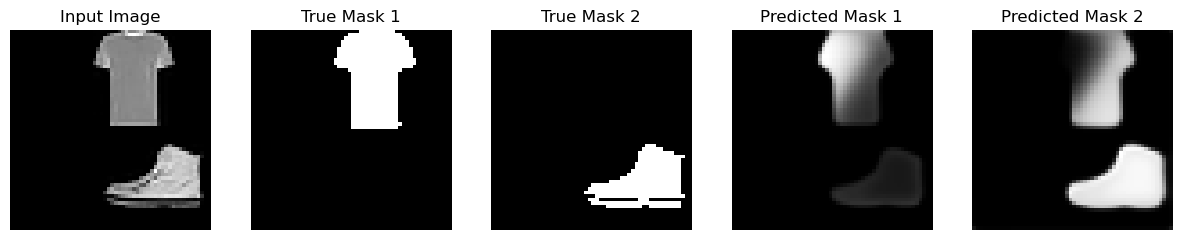

Object 1 Label: 0, Object 2 Label: 7


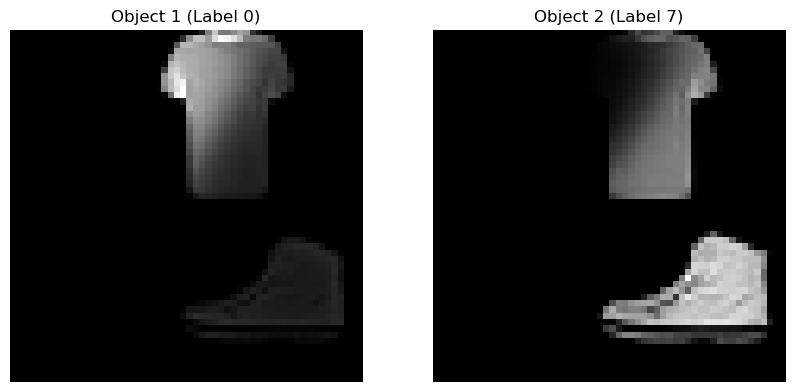

In [145]:
extract_and_classify_clothing(unet_model, test_loader, num_samples=1, device=device)

# Final

Epoch [1/1], Step [1/263], Loss: 0.6826
Epoch [1/1], Step [11/263], Loss: 0.5910
Epoch [1/1], Step [21/263], Loss: 0.6226
Epoch [1/1], Step [31/263], Loss: 0.4683
Epoch [1/1], Step [41/263], Loss: 0.3869
Epoch [1/1], Step [51/263], Loss: 0.3127
Epoch [1/1], Step [61/263], Loss: 0.2363
Epoch [1/1], Step [71/263], Loss: 0.1962
Epoch [1/1], Step [81/263], Loss: 0.1879
Epoch [1/1], Step [91/263], Loss: 0.1629
Epoch [1/1], Step [101/263], Loss: 0.2266
Epoch [1/1], Step [111/263], Loss: 0.1793
Epoch [1/1], Step [121/263], Loss: 0.1754
Epoch [1/1], Step [131/263], Loss: 0.1407
Epoch [1/1], Step [141/263], Loss: 0.1360
Epoch [1/1], Step [151/263], Loss: 0.1005
Epoch [1/1], Step [161/263], Loss: 0.0856
Epoch [1/1], Step [171/263], Loss: 0.0897
Epoch [1/1], Step [181/263], Loss: 0.0856
Epoch [1/1], Step [191/263], Loss: 0.0546
Epoch [1/1], Step [201/263], Loss: 0.0453
Epoch [1/1], Step [211/263], Loss: 0.0428
Epoch [1/1], Step [221/263], Loss: 0.0329
Epoch [1/1], Step [231/263], Loss: 0.1026
Epo

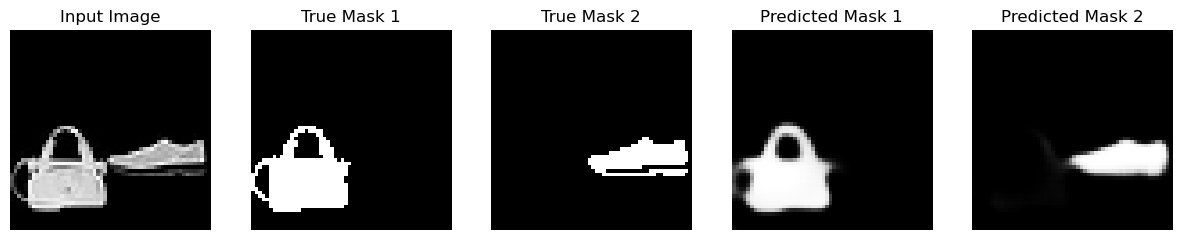

Object 1 Label: 8, Predicted Label: 1
Object 2 Label: 7, Predicted Label: 1


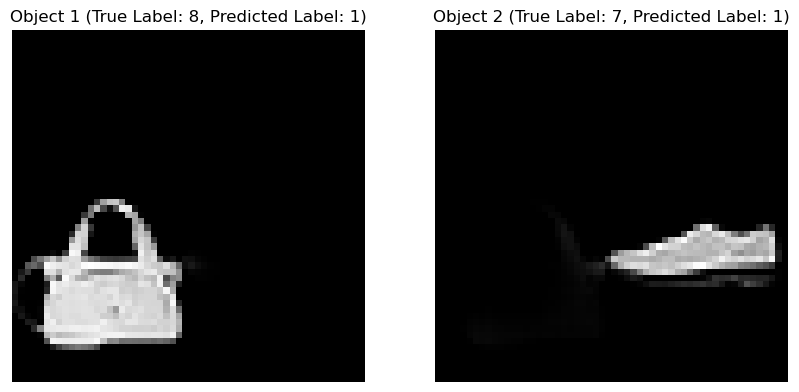

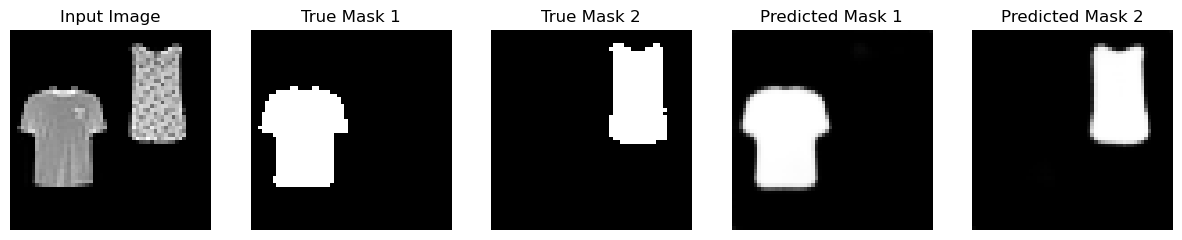

Object 1 Label: 0, Predicted Label: 1
Object 2 Label: 6, Predicted Label: 1


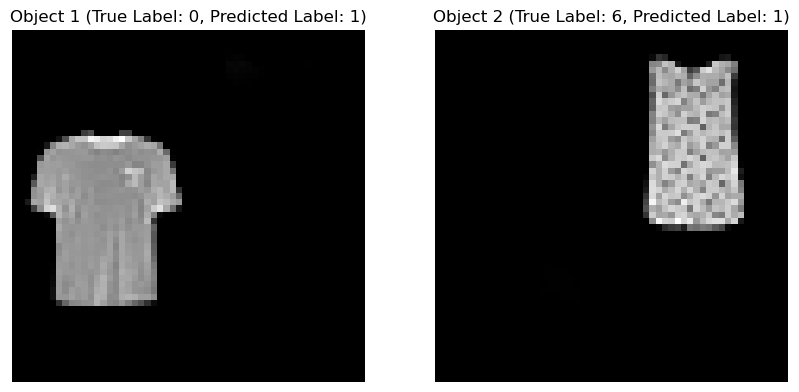

In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import numpy as np

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = datasets.FashionMNIST('.', train=True, download=True, transform=transformation)
full_test_dataset = datasets.FashionMNIST('.', train=False, download=True, transform=transformation)

full_dataset = torch.utils.data.ConcatDataset([full_train_dataset, full_test_dataset])

train_percent = 0.06
val_percent = 0.02

def split_dataset(dataset, train_percent=0.2, val_percent=0.05):
    total_size = len(dataset)
    train_size = int(train_percent * total_size)
    val_size = int(val_percent * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_test_dataset = random_split(dataset, [train_size, val_size + test_size])
    val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])
    
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, train_percent=train_percent, val_percent=val_percent)

test_subset = Subset(test_dataset, list(range(100)))
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

def create_mask(image, threshold=0.1):
    mask = (image > threshold).float()
    return mask

def create_samples_with_non_overlapping_images_and_vectors(train_loader, num_samples=100):
    samples = []
    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)

        idx1, idx2 = np.random.choice(len(train_loader.dataset), 2, replace=False)
        img1, label_1 = train_loader.dataset[idx1]
        img2, label_2 = train_loader.dataset[idx2]
        
        while label_1 == label_2:
            idx2 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
            img2, label_2 = train_loader.dataset[idx2]

        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        
        a = np.random.randint(-27, 28)
        if a >= 0:
            x1, y1 = a, 0
        else:
            x1, y1 = 0, abs(a)
        
        if x1 > 0 and y1 == 0:
            y2, x2 = 27, np.random.randint(0, 28)
        elif x1 == 0 and y1 == 0:
            b = np.random.randint(0, 56)
            if b < 28:
                x2, y2 = b, 27
            else:
                x2, y2 = 27, 55 - b
        else:
            x2, y2 = 27, np.random.randint(0, 28)
            
        background[:, y1:y1+28, x1:x1+28] = img1
        background[:, y2:y2+28, x2:x2+28] = img2
        
        mask1 = create_mask(img1)
        mask2 = create_mask(img2)
        
        combined_mask = torch.zeros((2, 56, 56))
        combined_mask[0, y1:y1+28, x1:x1+28] = mask1
        combined_mask[1, y2:y2+28, x2:x2+28] = mask2

        samples.append((background, combined_mask, label_1, label_2))

    return samples

def transform_loader(data_loader, num_samples=None):
    if num_samples is None:
        num_samples = len(data_loader.dataset)
    transformed_data = create_samples_with_non_overlapping_images_and_vectors(data_loader, num_samples)
    return transformed_data

train_data = transform_loader(train_loader)
val_data = transform_loader(val_loader)
test_data = transform_loader(test_loader)

train_dataset = [(sample[0], sample[1], sample[2], sample[3]) for sample in train_data]
val_dataset = [(sample[0], sample[1], sample[2], sample[3]) for sample in val_data]
test_dataset = [(sample[0], sample[1], sample[2], sample[3]) for sample in test_data]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = up_conv(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.dec1 = conv_block(128, 64)
        
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, self.crop(enc4, dec4)), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, self.crop(enc3, dec3)), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, self.crop(enc2, dec2)), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, self.crop(enc1, dec1)), dim=1)
        dec1 = self.dec1(dec1)
        
        output = self.conv_final(dec1)
        output = F.interpolate(output, size=(56, 56), mode='bilinear', align_corners=True)
        return output
    
    def crop(self, enc, dec):
        _, _, H, W = dec.size()
        enc = F.interpolate(enc, size=(H, W), mode='bilinear', align_corners=True)
        return enc

class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*14*14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_unet(model, train_loader, val_loader, num_epochs=1, learning_rate=0.001, device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, (imgs, masks, label1, label2) in enumerate(train_loader):
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Print progress
            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for imgs, masks, label1, label2 in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

def test_unet(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    test_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        for imgs, masks, label1, label2 in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            print(f"Batch Loss: {loss.item():.4f}")
    
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    
    return test_loss

def extract_and_classify_clothing(model, classifier, data_loader, num_samples=5, device='cpu'):
    model = model.to(device)
    classifier = classifier.to(device)
    model.eval()
    classifier.eval()
    
    samples = []
    with torch.no_grad():
        for imgs, masks, label1, label2 in data_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            samples.extend(zip(imgs.cpu(), masks.cpu(), outputs.cpu(), label1.cpu(), label2.cpu()))
            if len(samples) >= num_samples:
                break
    
    for i, (img, true_mask, pred_mask, label1, label2) in enumerate(samples[:num_samples]):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 5, 1)
        plt.title('Input Image')
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 2)
        plt.title('True Mask 1')
        plt.imshow(true_mask[0].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 3)
        plt.title('True Mask 2')
        plt.imshow(true_mask[1].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 4)
        plt.title('Predicted Mask 1')
        plt.imshow(torch.sigmoid(pred_mask[0]).squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 5, 5)
        plt.title('Predicted Mask 2')
        plt.imshow(torch.sigmoid(pred_mask[1]).squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.show()
        
        pred_mask1 = torch.sigmoid(pred_mask[0]).squeeze().numpy()
        pred_mask2 = torch.sigmoid(pred_mask[1]).squeeze().numpy()
        
        obj1_img = img * torch.tensor(pred_mask1).unsqueeze(0)
        obj2_img = img * torch.tensor(pred_mask2).unsqueeze(0)
        
        obj1_img = obj1_img.unsqueeze(0).to(device)
        obj2_img = obj2_img.unsqueeze(0).to(device)
        
        pred_label1 = classifier(obj1_img).argmax(dim=1).item()
        pred_label2 = classifier(obj2_img).argmax(dim=1).item()
        
        print(f'Object 1 Label: {label1}, Predicted Label: {pred_label1}')
        print(f'Object 2 Label: {label2}, Predicted Label: {pred_label2}')
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title(f'Object 1 (True Label: {label1}, Predicted Label: {pred_label1})')
        plt.imshow(obj1_img.squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title(f'Object 2 (True Label: {label2}, Predicted Label: {pred_label2})')
        plt.imshow(obj2_img.squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        
        plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model = UNet(in_channels=1, out_channels=2)
classifier_model = SimpleClassifier()
train_losses, val_losses = train_unet(unet_model, train_loader, val_loader, num_epochs=1, device=device)

test_loss = test_unet(unet_model, test_loader, device=device)

extract_and_classify_clothing(unet_model, classifier_model, test_loader, num_samples=2, device=device)